# Logistic Regression From Scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons

here is the logistic function

$$
f(x) = \frac{1}{1+e^{-x}}
$$

In [2]:
# lets create logistic function

def logistic(x):
    return 1 / (1 + np.exp(-x))

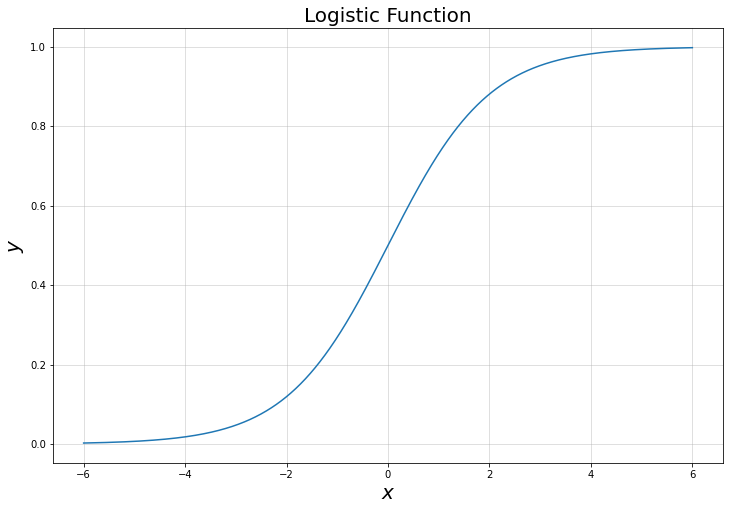

In [3]:
#plot logistic
plt.figure(figsize=(12,8))
x = np.linspace(-6, 6, 1000)
y = logistic(x)
plt.xlabel(r'$x$', size=20)
plt.ylabel(r'$y$', size=20)
plt.title(r'Logistic Function', size=20)
plt.grid(alpha=0.5)
plt.plot(x, y);

(500, 2)
(500,)


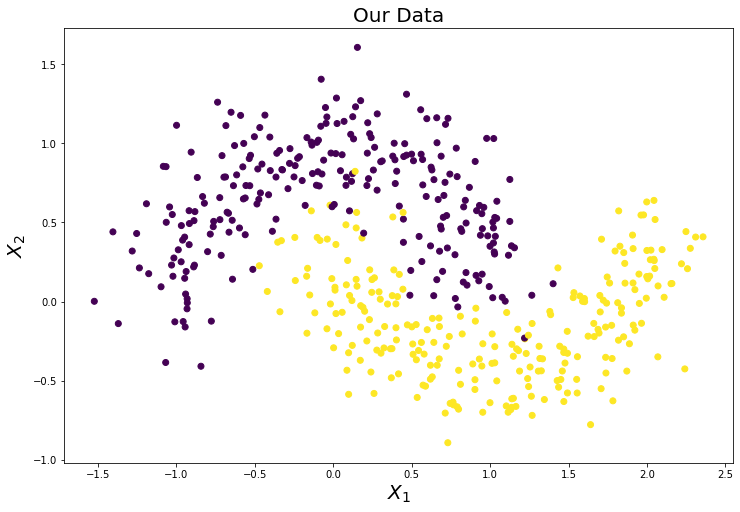

In [4]:
#X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=1)
X, y = make_moons(n_samples=500, noise=0.2, random_state=1)
plt.figure(figsize=(12,8))
plt.xlabel(r'$X_1$', size=20)
plt.ylabel(r'$X_2$', size=20)
plt.title(r'Our Data', size=20)
plt.scatter(X[:,0],X[:,1], c=y.reshape(-1));

#we have have feature size=2 (x_1, x_2)
#we have n=500 data pts
#we have binary class outputs (seen by colours)
print(X.shape)
print(y.shape)

Lets create training and test datasets!

In [5]:
#first 
#we need to combine our Design matrix (all the x's) with the y matrix (all the labels)


# stacking data X and labels y into one matrix
data = np.hstack((X, y[:, np.newaxis])) #<-- add new axis because y is currently a row vector and we want to stack column wise (next to each other)

# shuffling the rows        
np.random.shuffle(data)

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(data, [int(split_rate*(data.shape[0]))])

print(train.shape)
print(test.shape)

(350, 3)
(150, 3)


IMPORTANT!

We need to be sure our shapes are how we want them!

we need to work out $\theta^{T}X$
* our $\theta$.shape = (d, 1)
* therefore $\theta^{T}$.shape = (1, d)
* hence we need $X$.shape = (d, n)

Therefore we need to transpose $X$ (because its shape is (n, d) atm)

In [6]:
X_train = train[:,:-1].T
y_train = train[:, -1]

X_test = test[:,:-1].T
y_test = test[:, -1]

y_train = y_train.astype(int)
y_test = y_test.astype(int)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2, 350)
(350,)
(2, 150)
(150,)


In logistic regression, we learn parameters $\boldsymbol \theta$ and $\theta_0$ (the intercept) similar to linear regression, but pass the output through a logistic function in the end. We call the output of this operation $\hat{\boldsymbol y}_{\text{log}}$:
$$
\hat{\boldsymbol y}_{\text{log}} = g(\boldsymbol \theta^T \boldsymbol X + \theta_0)
$$

where $\boldsymbol X = [x^{(1)}, x^{(2)}, \dots, x^{(n)}]$, and $x^{(i)} \in \mathbb R^d$.

Note that $g$ is again the logistic function and, consequently, we have a _probability_ of the given data point belonging to one of the two classes!

In [7]:
def predict_log(X, theta, theta_0):
    return logistic(theta.T @ X + theta_0)

Let's initialise the parameters $\boldsymbol \theta$ and $\theta_0$ randomly or with zeros; we do the latter here.

In [8]:
def initialise(d):
    """    
    Argument:
    d: size of the theta vector (i.e. number of parameters)

    Returns:
    theta: initialised vector of shape (d, 1)
    theta_0: initialised scalar (corresponds to the offset/intercept)
    """

    theta = np.zeros(shape=(d, 1), dtype=np.float32)
    theta_0 = 0

    #we can use assertions for sanity checks!
    assert(theta.shape==(d, 1))
    assert(isinstance(theta_0, float) or isinstance(theta_0, int))

    return theta, theta_0

The cost function to be minimised (note the minus) is given by
$$
\mathcal L = - \frac{1}{n} \sum_{i=1}^n y^{(i)} \log(\hat{y}_{\text{log}}^{(i)}) + (1-y^{(i)}) \log (1-\hat{y}_{\text{log}}^{(i)}) \, .
$$

This stems from the likelihood! (i.e. this is the log-likelihood)

We will use gradient descent to optimise this cost function. The derivatives with respect to $\boldsymbol \theta$ and $\theta_0$ are:
$$
\frac{\partial \mathcal L}{\partial \boldsymbol \theta} = \frac{1}{n} \sum_{i=1}^n ( y^{(i)} - \hat{y}_{\text{log}}^{(i)}) x^{(i)}
$$
 
$$
\frac{\partial \mathcal L}{\partial \theta_0} = \frac{1}{n} \sum_{i=1}^n ( y^{(i)} - \hat{y}_{\text{log}}^{(i)})
$$

Let's implement the cost function and its derivatives in the next cell as part of a larger operation which we shall call `propagate`, which is often also called a _forward pass_.

In [9]:
def propagate(X, y, theta, theta_0):
    """
    Arguments:
    X: data of size (d, n)
    y: true label vector of size (1, n)
    theta: parameters, a numpy array of size (d, 1)
    theta_0: offset, a scalar

    Returns:
    cost: negative log-likelihood cost for logistic regression
    dtheta: gradient of the loss with respect to theta
    dtheta_0: gradient of the loss with respect to theta_0
    """
    
    n = X.shape[1]
    y_log = predict_log(X, theta, theta_0)

    #comupute the cost - note: we use np.multiply here to do the broadcasting! - axis=1 (across rows)
    cost = (-1) * np.mean(np.multiply(y, np.log(y_log)) + np.multiply(1 - y, np.log(1 - y_log)), axis=1)
    cost = np.squeeze(cost)
    
    #compute the gradients
    dtheta = (1/n) * X @ np.transpose(y_log - y) #here we have the right shapes just need to transpose! (no broadcasting)
    dtheta_0 = np.mean((y_log - y))
    
    assert(dtheta.shape == theta.shape)
    assert(dtheta_0.dtype == float)
    assert(cost.shape == ())
    
    #store gradients in a dictory
    grads = {"dtheta": dtheta, "dtheta_0": dtheta_0}
    
    return grads, cost

In [10]:
theta_test, theta_0_test = initialise(2)
grads_test, cost_test = propagate(X_train, y_train, theta_test, theta_0_test)

In [11]:
grads_test

{'dtheta': array([[-0.25290033],
        [ 0.18473745]]),
 'dtheta_0': -0.005714285714285714}

In [12]:
cost_test

array(0.69314718)

Now that we have a function that computes the cost/loss function (i.e. portrays how far our predictions are from true) and computes the gradients of the loss w.r.t $\theta$ and $\theta_0$. we have all that we need to conduct gradient decent (because of minius) optimization

In [13]:
def optimise(X, y, theta, theta_0, num_iterations=1000, learning_rate=0.005, print_cost=False):
    """
    Arguments:
    X: data of size (d, n)
    y: true label vector of size (1, n)
    theta: parameters, a numpy array of size (d, 1)
    theta_0: offset, a scalar
    num_iterations: number of iterations gradient descent shall update the parameters
    learning_rate: step size in updating procedure
    print_cost: whether to print the cost every 100 iterations or not

    Returns:
    params: dictionary containing the parameters theta and offset theta_0
    grads: dictionary containing the gradients
    costs: list of all the costs computed during the optimisation (can be used to plot the learning curve).
    """
    costs = []
    
    # iterate over the number of iterations:
    for i in range(num_iterations):
        
        #calculate the cost and gradients
        grads, cost = propagate(X, y, theta, theta_0)
        
        dtheta = grads['dtheta']
        dtheta_0 = grads['dtheta_0']
        
        #update the parameters
        theta = theta - learning_rate * dtheta
        theta_0 = theta_0 - learning_rate * dtheta_0
        
        # record the costs
        if i % 100 == 0:
            costs.append(cost)

        # print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("cost after iteration %i: %f" %(i, cost))
        
    # save parameters and gradients in dictionary
    params = {"theta": theta, "theta_0": theta_0}
    grads = {"dtheta": dtheta, "dtheta": dtheta_0}

    return params, grads, costs

Having calculated the parameters ($\theta$ and $\theta_0$) for our training sets, we can finally predict the labels for our test set.

In [14]:
def predict(X_test, theta, theta_0):
    """
    Arguments:
    X_test: test data of size (d, n)
    theta: parameters, a numpy array of size (d, 1)
    theta_0: offset, a scalar

    Returns:
    y_pred: vector containing all binary predictions (0/1) for the examples in X_test
    """
    
    n = X_test.shape[1] # X_test (d, n)
    
    #initilise
    y_pred = np.zeros((1,n))
    #just to make sure its of the right shape (d, 1)
    theta = theta.reshape(X_test.shape[0], 1)

    # compute vector y_log predicting the probabilities
    y_log = predict_log(X_test, theta, theta_0)

    for i in range(y_log.shape[1]):

      # convert probabilities y_log to actual predictions y_pred
        if y_log[0, i] > 0.5:
            y_pred[0, i] = 1  
        else:
            y_pred[0, i] = 0  

    assert(y_pred.shape==(1, n))

    return y_pred

We can now bring it all together to define our model!

In [15]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    
    # initialize parameters with zeros
    theta, theta_0 = initialise(X_train.shape[0])

    # gradient descent
    parameters, grads, costs = optimise(X_train, y_train, theta, theta_0, num_iterations, learning_rate, print_cost=print_cost)

    # retrieve parameters theta and theta_0 from dictionary "parameters"
    theta = parameters["theta"]
    theta_0 = parameters["theta_0"]

    # predict test and train set examples
    y_pred_test = predict(X_test, theta, theta_0)
    y_pred_train = predict(X_train, theta, theta_0)

    # print train/test Errors
    print('')
    print("train accuracy: {} %".format(round(100 - np.mean(np.abs(y_pred_train - y_train)) * 100, 2)))
    print("test accuracy: {} %".format(round(100 - np.mean(np.abs(y_pred_test - y_test)) * 100, 2)))

    # saving all information
    d = {"costs": costs, "y_pred_test": y_pred_test, "y_pred_train": y_pred_train, "theta": theta, "theta_0": theta_0, "learning_rate": learning_rate, "num_iterations": num_iterations}

    return d

In [16]:
# run the model
d = model(X_train, y_train, X_test, y_test, num_iterations=500, learning_rate=0.1, print_cost=True)

cost after iteration 0: 0.693147
cost after iteration 100: 0.396112
cost after iteration 200: 0.346117
cost after iteration 300: 0.324473
cost after iteration 400: 0.311923

train accuracy: 86.57 %
test accuracy: 84.67 %


In [17]:
d

{'costs': [array(0.69314718),
  array(0.39611235),
  array(0.34611693),
  array(0.32447321),
  array(0.31192301)],
 'y_pred_test': array([[1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
         0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
         1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
         1., 0., 0., 1., 0., 1.]]),
 'y_pred_train': array([[0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0.

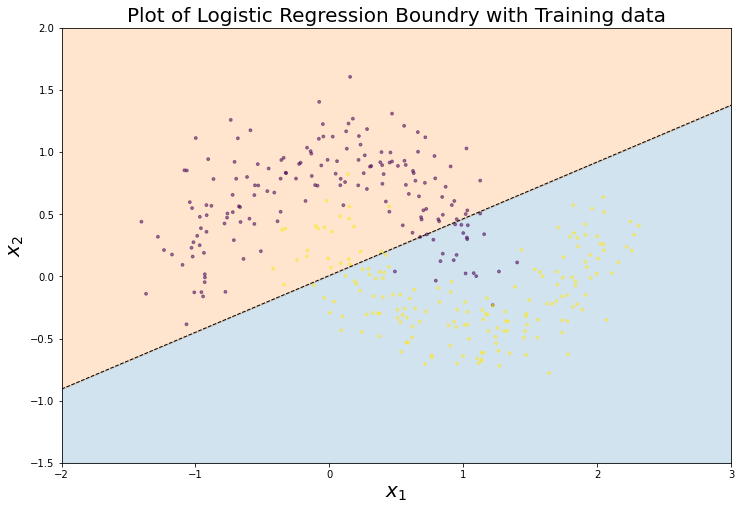

In [45]:
import numpy as np
import matplotlib.pyplot as plt


X = X_train.T
Y = y_train

# Retrieve the model parameters.
b = d['theta_0']

w1, w2 = np.squeeze(d['theta'])

# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -2, 3
ymin, ymax = -1.5, 2
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.figure(figsize=(12, 8))
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=8, alpha=0.5)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$', size=20)
plt.xlabel(r'$x_1$', size=20)
plt.title(r'Plot of Logistic Regression Boundry with Training data', size=20)


plt.show()

here is the link for the plot and the maths behind it: 
https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/